In [1]:
import torch
import torch.nn as nn
# For the use of padding
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm
from torch.utils.data import DataLoader
import torch.utils.data as Data
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from sklearn.metrics import confusion_matrix
from copy import deepcopy
from nltk.tokenize import TweetTokenizer
import nltk
from urllib.parse import urlparse
import re
import itertools
import gensim
import os
from nltk.corpus import wordnet as wn  # For WordNet
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from sklearn.model_selection import train_test_split
from collections import defaultdict
import time
import pickle
import pandas as pd
from torch.utils.data import WeightedRandomSampler

%matplotlib inline

'''
TODO:

1. Change the BCELogistic Weight
2. Loading Wiht the Right Device "cuda"
3. Write the ReadMe of GitHub
4. 
'''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class args(object):

    # Data
    
    full_data = True
    if full_data: 
        pickle_name = "FullPickleData.txt"
    else:
        pickle_name = "10thPickleData.txt"
    dataset_path = ""  # load a dataset and setting
    vocab_size = 8000

    # Arch

    usingPretrainedEmbedding = False
    if usingPretrainedEmbedding:
        embedding_dim = 300
    else:
        embedding_dim = 256

    RNN_hidden = 128
    num_CNN_filter = 64
    CNN_kernel_size = 5
    LSTM_dropout = 0.1

    # Training params

    confusion_matrics = []
    
    batch_size = 64
    L2 = 0.1
    threshold = 0.5
    lr = 0.002
    n_epoch = 50

    # If using Adam
    adam_beta1 = 0.9
    adam_beta2 = 0.999
    adam_weight_decay = 0.01

    # Logging the Training
    val_freq = 200
    val_steps = 3
    log_freq = 10
    model_save_freq = 1
    model_name = 'SSCL'
    model_path = './' + model_name + '/Model/'
    log_path = './' + model_name + '/Log/'


# Create the path for saving model and the log
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

if not os.path.exists(args.log_path):
    os.makedirs(args.log_path)


class Constants():
    ''' The Constants for the text '''
    PAD = 0
    UNK = 1
    SOS = 2
    EOS = 3

    PAD_WORD = '<PAD>'
    UNK_WORD = '<UNK>'
    SOS_WORD = '<SOS>'
    EOS_WORD = '<EOS>'


specialTokens = {
    Constants.PAD_WORD: Constants.PAD,
    Constants.UNK_WORD: Constants.UNK,
    Constants.SOS_WORD: Constants.SOS,
    Constants.EOS_WORD: Constants.EOS,
}

specialTokenList = [Constants.PAD_WORD,
                    Constants.UNK_WORD,
                    Constants.SOS_WORD,
                    Constants.EOS_WORD]


# Load Google's pre-trained Word2Vec model.
# model = gensim.models.KeyedVectors.load_word2vec_format(
#     './GoogleNews-vectors-negative300.bin', binary=True)

# word2vector = torch.FloatTensor(model.vectors)


class SSCL(nn.Module):

    ''' The Model from paper '''

    def __init__(self,):
        super(SSCL, self).__init__()

        if args.usingPretrainedEmbedding:
            self.embed = nn.Embedding.from_pretrained(word2vector)
        else:
            self.embed = nn.Embedding(
                args.vocab_size, args.embedding_dim, Constants.PAD)

        self.cnn = nn.Sequential(
            nn.Conv1d(args.embedding_dim, args.num_CNN_filter,
                      args.CNN_kernel_size, 1, 2),
            nn.BatchNorm1d(args.num_CNN_filter),
            nn.LeakyReLU(inplace=True),
            nn.Conv1d(args.num_CNN_filter, args.num_CNN_filter*2,
              args.CNN_kernel_size, 1, 2),
            nn.BatchNorm1d(args.num_CNN_filter*2),
            nn.LeakyReLU(inplace=True),
            nn.Conv1d(args.num_CNN_filter*2, args.num_CNN_filter,
              args.CNN_kernel_size, 1, 2),
            nn.BatchNorm1d(args.num_CNN_filter),
            nn.LeakyReLU(inplace=True),
        )

        self.rnn = nn.LSTM(args.num_CNN_filter, args.RNN_hidden,
                           batch_first=True, dropout=args.LSTM_dropout, num_layers = 4)

        self.out_net = nn.Sequential(
            nn.Linear(128, 1),
        )

        self.h0 = nn.Parameter(torch.randn(1, args.RNN_hidden))
        self.c0 = nn.Parameter(torch.randn(1, args.RNN_hidden))

#         self.apply(self.weight_init)

    def forward(self, input, lengths=None):

        B = input.size(0)

        emb_out = self.embed(input).transpose(1, 2)

        out = self.cnn(emb_out).transpose(1, 2)

        if not lengths is None:
            out = pack_padded_sequence(out, lengths, batch_first=True)
            out, hidden = self.rnn(
                out, (self.h0.repeat(1, B, 1), self.c0.repeat(1, B, 1)))
            out = pad_packed_sequence(out, batch_first=True)[0][:, -1, :]
        else:
            #             out = self.rnn(out,(self.h0.repeat(1,B,1), self.c0.repeat(1,B,1)))[0][:, -1, :]
            out = self.rnn(out)[0][:, -1, :]

        out = self.out_net(out)

        return out

    def weight_init(self, m):

        if type(m) in [nn.Conv2d, nn.ConvTranspose2d, nn.Linear]:
            nn.init.kaiming_normal_(m.weight, 0.2, nonlinearity='leaky_relu')
        elif type(m) in [nn.LSTM]:
            for name, value in m.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_normal_(value.data)
                if 'bias'in name:
                    value.data.normal_()

# We can put all the lost function and the optimization into the args

class Trainer(nn.Module):

    def __init__(self,):
        super(Trainer, self).__init__()
        
        numberOfSpammer = training_dataset.tensors[2].sum()
        numberOfNoSpammer = len(training_dataset)-training_dataset.tensors[2].sum()
        
        self.SSCL = SSCL()
        self.optim = optim.Adam(
            self.SSCL.parameters(), lr=args.lr, weight_decay=args.adam_weight_decay)
        self.Loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(numberOfNoSpammer/numberOfSpammer)*1.5)
        self.hist = defaultdict(list)

    def forward(self, input, label):

        if type(input) is tuple:
            input, lengths = input
        else:
            lengths = None

        self.pred = self.SSCL(input, lengths)

        loss = self.Loss(self.pred.squeeze(1), label)

        accuracy = torch.mean(
            ((self.pred > args.threshold) == label.byte()).float())
        
        args.confusion_matrics.insert(0, confusion_matrix(label.cpu().numpy(), (self.pred > args.threshold).cpu().numpy()))
        
        args.confusion_matrics = args.confusion_matrics[:10]

        return loss, accuracy

    def train_step(self, input, label):

        self.optim.zero_grad()

        self.loss, self.accuracy = self.forward(input, label)

        self.hist["Temp_Train_Loss"].append(self.loss.item())
        self.hist["Temp_Train_Accuracy"].append(self.accuracy.item())
        self.hist["Train_Loss"].append(self.loss.item())
        self.hist["Train_Accuracy"].append(self.accuracy.item())

        self.loss.backward()
        self.optim.step()

    def test_step(self, input, label, validation=True):

        # Not Updating the weight

        self.loss, self.accuracy = self.forward(input, label)

        if validation:
            self.hist["Temp_Val_Loss"].append(self.loss.item())
            self.hist["Temp_Val_Accuracy"].append(self.accuracy.item())
            self.hist["Val_Loss"].append(self.loss.item())
            self.hist["Val_Accuracy"].append(self.accuracy.item())
        else:
            self.hist["Temp_Test_Loss"].append(self.loss.item())
            self.hist["Temp_Test_Accuracy"].append(self.accuracy.item())
            self.hist["Test_Loss"].append(self.loss.item())
            self.hist["Test_Accuracy"].append(self.accuracy.item())

    def calculateAverage(self,):

        temp_keys = deepcopy(list(trainer.hist.keys()))
        for name in temp_keys:
            if 'Temp' in name:
                self.hist["Average" + name[4:]
                          ].append(sum(self.hist[name])/len(self.hist[name]))
                self.hist[name] = []

    def plot_train_hist(self, step):
        fig = plt.figure(figsize=(20, 10))
        num_loss = 2
        i = 0
        for name in self.hist.keys():
            if 'Train' in name and not "Temp" in name and not "Average" in name:
                i += 1
                fig.add_subplot(num_loss, 1, i)
                plt.plot(self.hist[name], label=name)
                plt.xlabel('Number of Steps', fontsize=15)
                plt.ylabel(name, fontsize=15)
                plt.title(name, fontsize=30, fontweight="bold")
                plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()
        fig.savefig(args.log_path+"Train_Loss&Acc_Hist"+str(step)+".png")

    def plot_all(self, step=None):
        
        fig = plt.figure(figsize=(20, 10))
        for name in self.hist.keys():
            if "Average" in name:
                if 'Loss' in name:
                    plt.subplot(211)
                    plt.plot(self.hist[name], marker='o', label=name)
                    plt.ylabel('Loss', fontsize=15)
                    plt.xlabel('Number of epochs', fontsize=15)
                    plt.title('Loss', fontsize=20, fontweight="bold")
                    plt.legend(loc='upper left')
                if "Accuracy" in name:
                    plt.subplot(212)
                    plt.plot(self.hist[name], marker='o', label=name)
                    plt.ylabel('Accuracy', fontsize=15)
                    plt.xlabel('Number of epochs', fontsize=15)
                    plt.title('Accuracy', fontsize=20, fontweight="bold")
                    plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()
        if step is not None:
            fig.savefig(args.log_path +"All_Hist"+str(step)+".png")

    def model_save(self, step):

        path = args.model_path + args.model_name+'_Step_' + str(step) + '.pth'
        torch.save({args.model_name: self.state_dict()}, path)
        print('Model Saved')

    def load_step_dict(self, step):

        path = args.model_path + args.model_name + \
            '_Step_' + str(step) + '.pth'
        self.load_state_dict(torch.load(
            path, map_location=lambda storage, loc: storage)[args.model_name])
        print('Model Loaded')

    def num_all_params(self,):
        return sum([param.nelement() for param in self.parameters()])

if not os.path.isfile(args.pickle_name):

    def matchingURL(match):
        args.match = match
        try:
            return urlparse(match.group()).netloc or match.group().split("/")[0]
        except:
    #         print("The matching URL: " ,match)
    #         print("The Extracted webAdd: ",match.group().split("/")[0])
            return match.group().split("/")[0]

    def preprocessingInputDataForLoop(input):

        allText = [i for i in input]

        preprocessedText = []

        for sentence in allText:

            out_ = re.sub(r"http\S+|www.\S+",matchingURL, sentence)

            out_ = re.sub(r'\d+', '', out_)

            out_ = out_.lower()

            out_ = tknzr.tokenize(out_)

            preprocessedSentence =[]

            for word in out_:

                if word not in nltk.corpus.stopwords.words('english') and len(word) >= 3:

                    preprocessedSentence.append(ps.stem(word))

            preprocessedText.append(preprocessedSentence)

        return preprocessedText

    def preprocessingInputData(input):
        allText = [i for i in input]
        preprocessedText = [[ps.stem(word) for word in tknzr.tokenize(re.sub(r'\d+', '', re.sub(r"http\S+|www.\S+", matchingURL, sentence)).lower()) if word not in nltk.corpus.stopwords.words('english') and len(word) >= 3] for sentence in allText]
        return preprocessedText

    # def preprocessingInputData(input):
    #     allText = [i for i in input]
    #     preprocessedText = [[ps.stem(word) for word in tknzr.tokenize(re.sub(r'\d+', '', re.sub(r"http\S+|www.\S+", lambda match: urlparse(match.group(
    #     )).netloc or match.group().split("/")[0], sentence)).lower()) if word not in nltk.corpus.stopwords.words('english') and len(word) >= 3] for sentence in allText]
    #     return preprocessedText


    def mapFromWordToIdx(input):

        wholeText = []

        for s in input:
            sentence = [2]
            for w in s:
                if w in text.tokens:
                    sentence.append(text.index(w))
                else:
                    sentence.append(1)
            sentence.append(3)
            wholeText.append(sentence)

        return wholeText

    def CreateDatatset(X, y):

        X_len = torch.tensor(list(map(len, X)))
        X_len, X_len_idx = X_len.sort(0, descending=True)

        X_ordered = [torch.LongTensor(X[i]) for i in X_len_idx]
        X_p = pad_sequence(X_ordered, batch_first=True)
        y = torch.FloatTensor(np.array(y))
        dataset = Data.TensorDataset(X_p, X_len, y)

        return dataset
    
    print("Loading Origin Data")
    
    if args.full_data:
        df = pd.read_html('FullDataFromSQLHSpam14.html')[0].iloc[1:,:]
    else:
        df_noSPammer = pd.read_html('textMaliciousMark_10th_NotSpammer.html')
    #     df_noSPammer = pd.read_html('textMaliciousMark_Small_NotSpammer.html')
        df_noSPammer = df_noSPammer[0][1:]
        df_Spammer = pd.read_html('textMaliciousMark_10th_Spammer.html')
    #     df_Spammer = pd.read_html('textMaliciousMark_Small_Spammer.html')
        df_Spammer = df_Spammer[0][1:]
        df = pd.concat([df_Spammer, df_noSPammer])
        del df_noSPammer, df_Spammer
        
    tknzr = TweetTokenizer()
    ps = nltk.stem.PorterStemmer()
    
    print("Data Splitation")

    X_train, X_test, Y_train, Y_test = train_test_split(
        df[0], df[1], test_size=0.2, stratify=df[1], random_state=64)
    X_test, X_validation, Y_test, Y_validation = train_test_split(
        X_test, Y_test, test_size=0.5, stratify=Y_test, random_state=64)
    
    print("Preprocessing X_train")
    
    X_train = preprocessingInputData(X_train)
    
    print("Generating text")
        
    # Preparing the dictionary
    text = nltk.Text(list(itertools.chain(*X_train)))
    len(dict(text.vocab()))  # number of the vocab
    text.tokens  # this is the idx -> word
    text.index("t.co")  # this. is the word -> idx
    
    ## Setting up the vocab size
    args.vocab_size = args.vocab_size or len(text.tokens)
    
    if args.vocab_size:
        text.tokens = specialTokenList + [w for w, _ in text.vocab().most_common(args.vocab_size - len(specialTokenList))]
    else:
        text.tokens = specialTokenList + text.tokens
        
    args.vocab_size = len(text.tokens)
    
    print("Generating Datasets")
    
    training_dataset = CreateDatatset(
        mapFromWordToIdx(X_train), list(map(int, list(Y_train))))

    print("Preprocessing X_validation")
    
    X_validation = preprocessingInputData(X_validation)

    validation_dataset = CreateDatatset(mapFromWordToIdx(
        X_validation), list(map(int, list(Y_validation))))
    
    print("Preprocessing X_test")

    X_test = preprocessingInputData(X_test)

    test_dataset = CreateDatatset(mapFromWordToIdx(
        X_test), list(map(int, list(Y_test))))
    
    print("Dumping Data")
    
    with open(args.pickle_name, "wb") as fp:   #Pickling
        pickle.dump([training_dataset, validation_dataset, test_dataset, text],fp) 
        print("The Pickle Data Dumped")
    
else:
    print("Loading Existing File: ", args.pickle_name)
    with open(args.pickle_name, "rb") as fp:   # Unpickling    
        training_dataset, validation_dataset, test_dataset, text = pickle.load(fp)
        args.vocab_size = args.vocab_size or len(text.tokens)
    

Loading Existing File:  FullPickleData.txt


In [2]:
numberOfSpammer = training_dataset.tensors[2].sum()
numberOfNoSpammer = len(training_dataset)-training_dataset.tensors[2].sum()

In [3]:
sampler = WeightedRandomSampler([10000,1], args.batch_size)

train_loader = DataLoader(
    training_dataset, batch_size=args.batch_size, shuffle=False, drop_last=False, sampler = sampler)
valid_loader = DataLoader(
    validation_dataset, batch_size=args.batch_size, shuffle=True, drop_last=False)

trainer = Trainer().to(device)

trainer.num_all_params()

scheduler = optim.lr_scheduler.StepLR(trainer.optim, 2000, gamma=0.85)
# trainer.optim.param_groups[0]['lr']=
allStep = 0
epoch = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


| Epoch [0] | Step [1] | lr [0.002000] | Loss: [0.6884] | Acc: [1.0000] | Time: 0.1s
Model Saved
| Epoch [1] | Step [2] | lr [0.002000] | Loss: [0.6553] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [2] | Step [3] | lr [0.002000] | Loss: [0.6235] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [3] | Step [4] | lr [0.002000] | Loss: [0.5904] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [4] | Step [5] | lr [0.002000] | Loss: [0.5532] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [5] | Step [6] | lr [0.002000] | Loss: [0.5083] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [6] | Step [7] | lr [0.002000] | Loss: [0.4526] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [7] | Step [8] | lr [0.002000] | Loss: [0.3826] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [8] | Step [9] | lr [0.002000] | Loss: [0.2952] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [9] | Step [10] | lr [0.002000] | Loss: [0.2003] | Acc: [1.0000] | Time: 0.0s


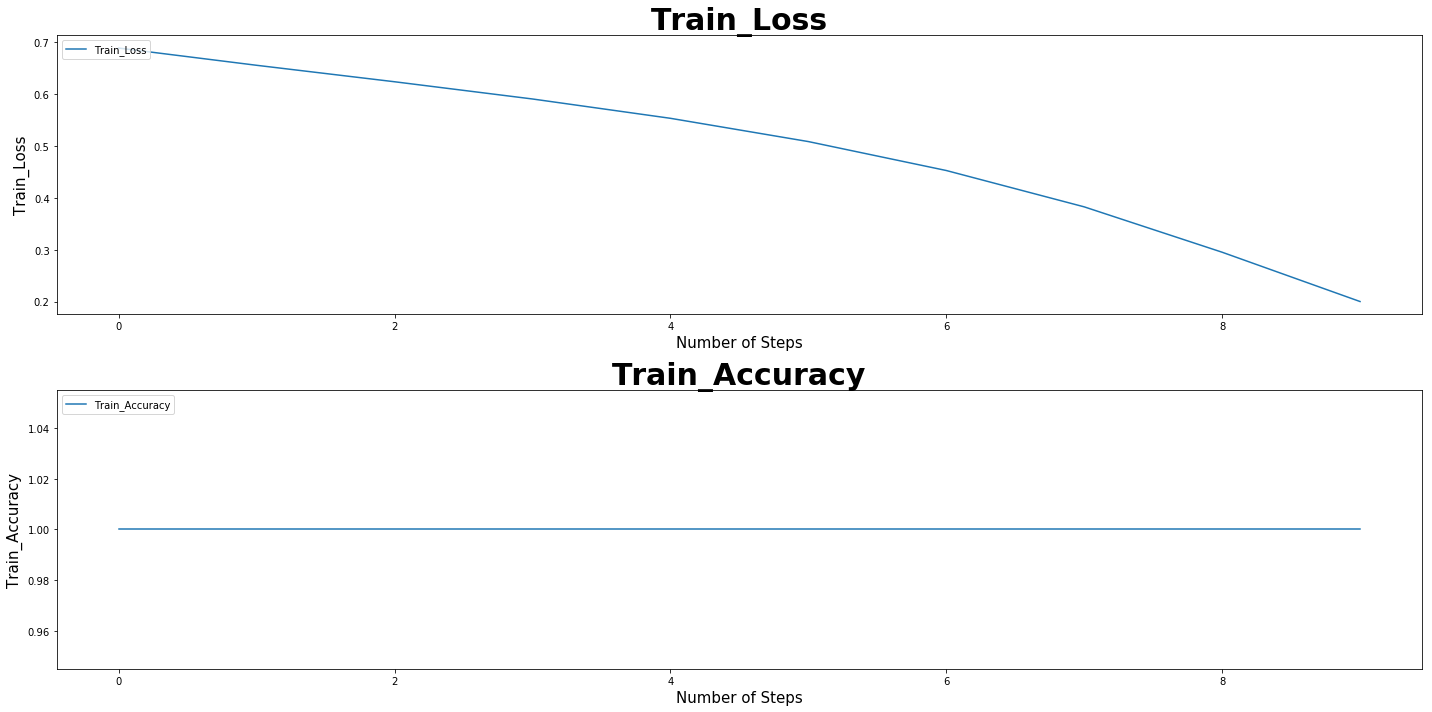

Model Saved
| Epoch [10] | Step [11] | lr [0.002000] | Loss: [0.1192] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [11] | Step [12] | lr [0.002000] | Loss: [0.0671] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [12] | Step [13] | lr [0.002000] | Loss: [0.0385] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [13] | Step [14] | lr [0.002000] | Loss: [0.0231] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [14] | Step [15] | lr [0.002000] | Loss: [0.0147] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [15] | Step [16] | lr [0.002000] | Loss: [0.0098] | Acc: [1.0000] | Time: 0.1s
Model Saved
| Epoch [16] | Step [17] | lr [0.002000] | Loss: [0.0070] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [17] | Step [18] | lr [0.002000] | Loss: [0.0053] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [18] | Step [19] | lr [0.002000] | Loss: [0.0043] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [19] | Step [20] | lr [0.002000] | Loss: [0.0036] | Acc: [1.0000] | Time: 0.0s


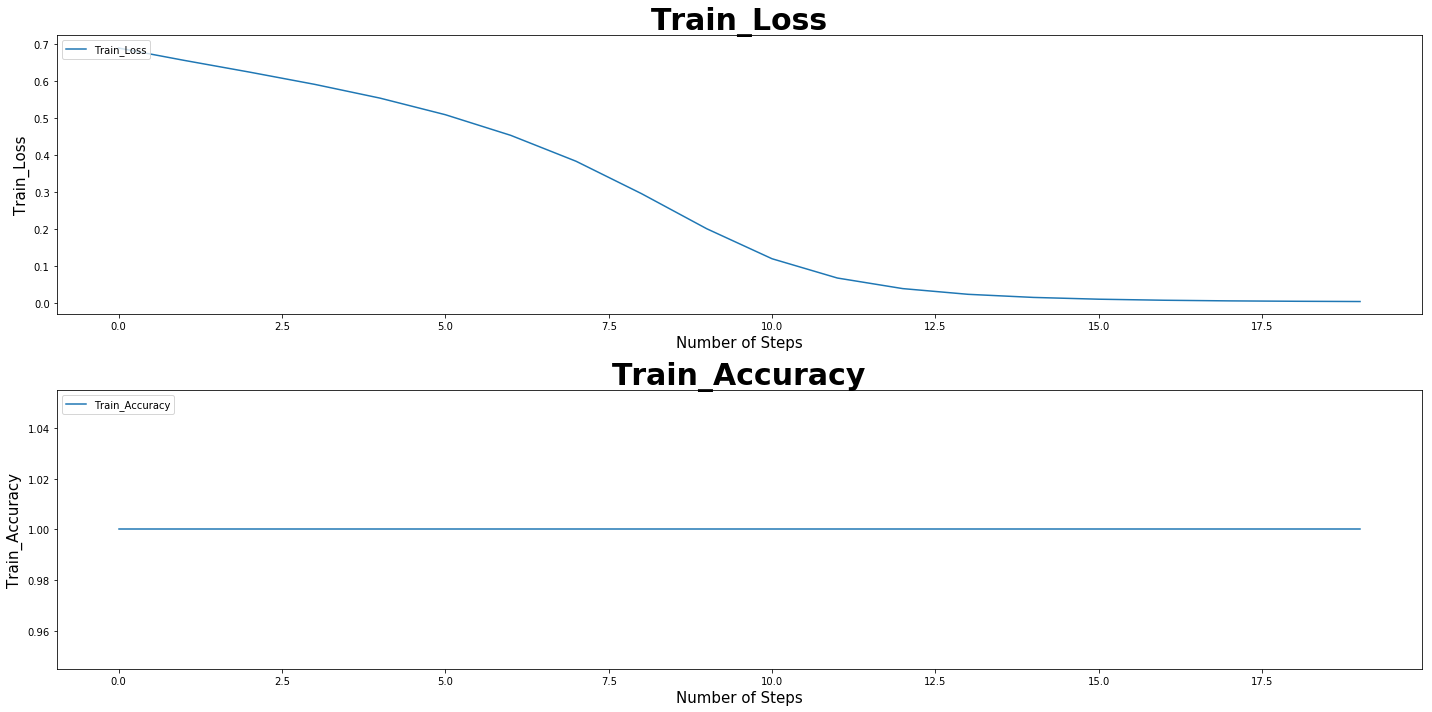

Model Saved
| Epoch [20] | Step [21] | lr [0.002000] | Loss: [0.0031] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [21] | Step [22] | lr [0.002000] | Loss: [0.0029] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [22] | Step [23] | lr [0.002000] | Loss: [0.0028] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [23] | Step [24] | lr [0.002000] | Loss: [0.0028] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [24] | Step [25] | lr [0.002000] | Loss: [0.0028] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [25] | Step [26] | lr [0.002000] | Loss: [0.0030] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [26] | Step [27] | lr [0.002000] | Loss: [0.0033] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [27] | Step [28] | lr [0.002000] | Loss: [0.0037] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [28] | Step [29] | lr [0.002000] | Loss: [0.0043] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [29] | Step [30] | lr [0.002000] | Loss: [0.0051] | Acc: [1.0000] | Time: 0.0s


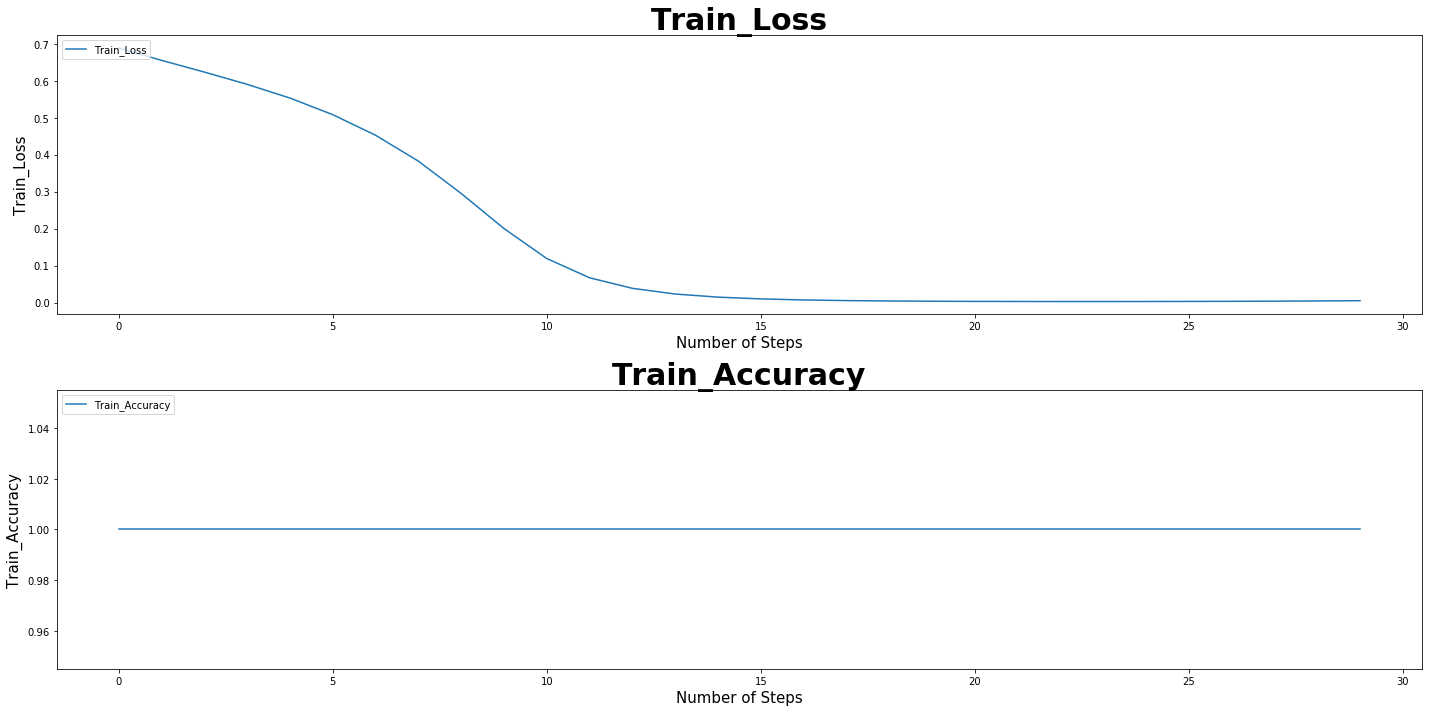

Model Saved
| Epoch [30] | Step [31] | lr [0.002000] | Loss: [0.0060] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [31] | Step [32] | lr [0.002000] | Loss: [0.0071] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [32] | Step [33] | lr [0.002000] | Loss: [0.0084] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [33] | Step [34] | lr [0.002000] | Loss: [0.0097] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [34] | Step [35] | lr [0.002000] | Loss: [0.0112] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [35] | Step [36] | lr [0.002000] | Loss: [0.0126] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [36] | Step [37] | lr [0.002000] | Loss: [0.0136] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [37] | Step [38] | lr [0.002000] | Loss: [0.0142] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [38] | Step [39] | lr [0.002000] | Loss: [0.0143] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [39] | Step [40] | lr [0.002000] | Loss: [0.0136] | Acc: [1.0000] | Time: 0.0s


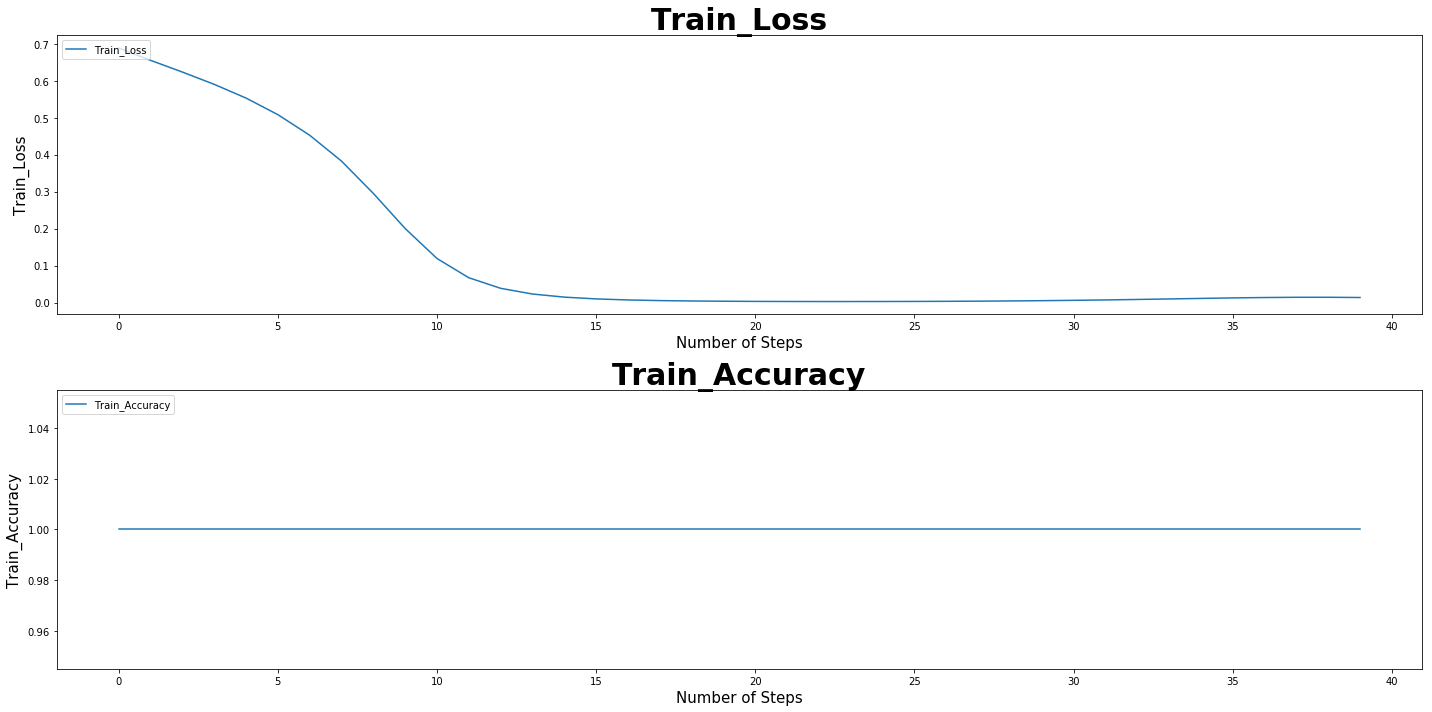

Model Saved
| Epoch [40] | Step [41] | lr [0.002000] | Loss: [0.0124] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [41] | Step [42] | lr [0.002000] | Loss: [0.0107] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [42] | Step [43] | lr [0.002000] | Loss: [0.0089] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [43] | Step [44] | lr [0.002000] | Loss: [0.0071] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [44] | Step [45] | lr [0.002000] | Loss: [0.0056] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [45] | Step [46] | lr [0.002000] | Loss: [0.0044] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [46] | Step [47] | lr [0.002000] | Loss: [0.0036] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [47] | Step [48] | lr [0.002000] | Loss: [0.0030] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [48] | Step [49] | lr [0.002000] | Loss: [0.0027] | Acc: [1.0000] | Time: 0.0s
Model Saved
| Epoch [49] | Step [50] | lr [0.002000] | Loss: [0.0025] | Acc: [1.0000] | Time: 0.0s


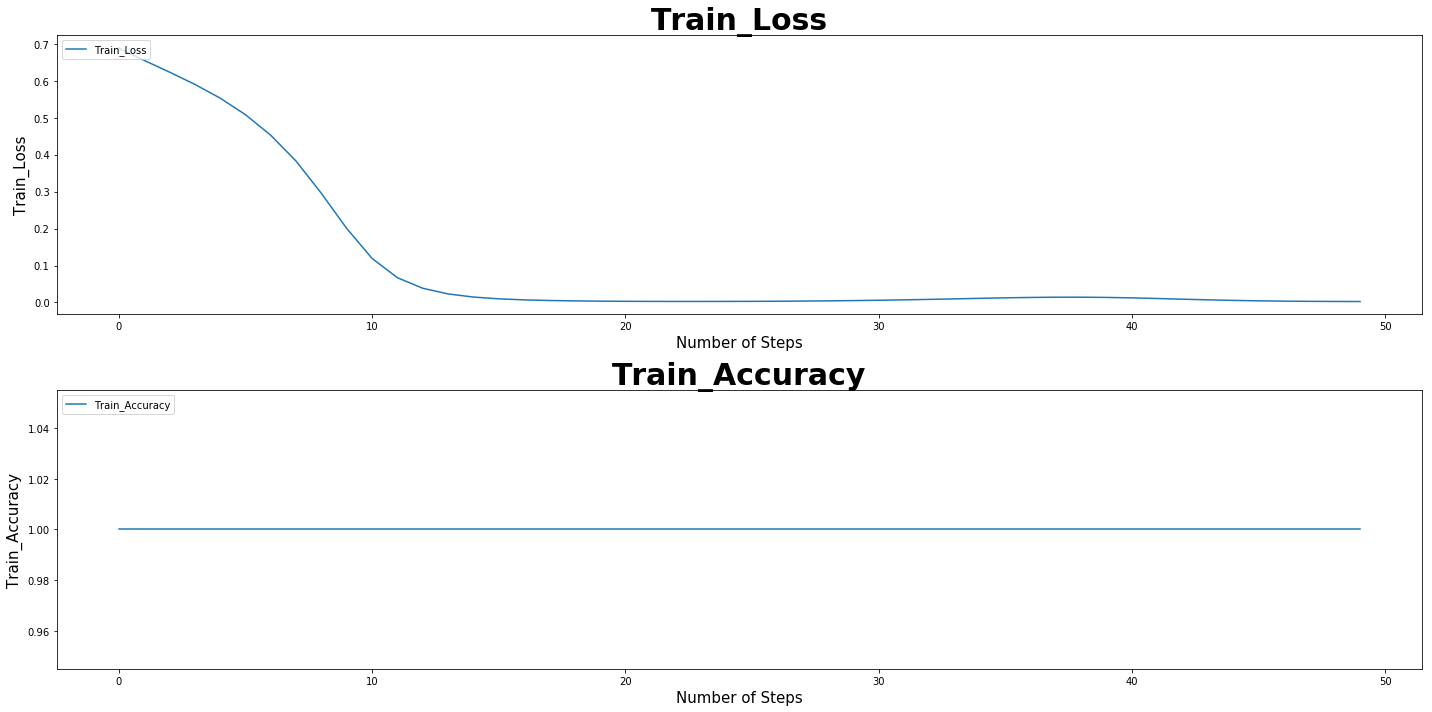

Model Saved


In [4]:
while epoch < args.n_epoch:
    for i, (X, X_len, y) in enumerate(train_loader):
        trainer.train()
        
        
        X, X_len, y = X.to(device), X_len.to(device), y.to(device)
        
        args.obser = y
        
        if trainer.optim.param_groups[0]['lr'] >= 0.00001:
            scheduler.step()
        start_t = time.time()
#         trainer.train_step((X, X_len), y)
        trainer.train_step(X, y)

        end_t = time.time()
        allStep += 1
        print('| Epoch [%d] | Step [%d] | lr [%.6f] | Loss: [%.4f] | Acc: [%.4f] | Time: %.1fs' %
              (epoch, allStep, trainer.optim.param_groups[0]['lr'], trainer.loss.item(), trainer.accuracy.item(),
               end_t - start_t))

#         if trainer.accuracy.item() > 0.95: # Stop early
#             raise StopIteration
        if allStep % args.log_freq == 0:
            trainer.plot_train_hist('_SSCL')

        if allStep % args.val_freq == 0:

            for _ in range(args.val_steps):
                trainer.eval()
                stIdx = np.random.randint(
                    0, len(validation_dataset) - args.batch_size)
                v_X, v_X_len, v_y = validation_dataset[stIdx: stIdx +
                                                       args.batch_size]
                v_X, v_X_len, v_y = v_X.to(
                    device), v_X_len.to(device), v_y.to(device)
                start_t = time.time()
#                 trainer.test_step((v_X, v_X_len), v_y)
                trainer.test_step(v_X, v_y)
                end_t = time.time()
                print('| Epoch [%d] | Validation | Step [%d] |  Loss: [%.4f] | Acc: [%.4f] | Time: %.1fs' %
                      (epoch, allStep, trainer.loss.item(), trainer.accuracy.item(), end_t - start_t))
            trainer.calculateAverage()
            clear_output()            
            trainer.plot_all('_SSCL')
            
     # After every Epoch, if can be moved

    epoch += 1
    trainer.model_save(epoch)

#     if epoch >= 20:
#         raise StopIteration


In [7]:
device

device(type='cuda')